In [5]:
from dsc80_utils import *

# Lecture 10 – Web Scraping

## DSC 80, Spring 2024

### Announcements 📣

- Lab 5 due tomorrow.
- Project 3 checkpoint due Friday.
- **If at least 80% of the class fills out the [Mid-Quarter Survey](https://forms.gle/bTfFohZos7Q8o1Y47) by Saturday at 11:59PM, everyone will get 1 extra credit point towards your Midterm Exam grade.**

### Your Midterm Scores

- I typically need to curve up the grades at the end of the quarter to match the historical average for the course (B+).
- Class average was 50%, which means that a 50% on the midterm roughly corresponds to getting a B+.

**Ouch, question 2 was hard, how would I approach questions like that in the future?**

- Don't get stuck -- skip it when you first encounter it.
- Don't panic -- hard questions are hard for everyone, so make as much progress as you can.
- As I often say during class, try to solve a simpler version of the problem.
- Make up a small example and work it out.
- If the question says "Show your work", you should show your work!

### Agenda 📆 

- Review: Accessing HTML.
- HTML basics.
- Parsing HTML using BeautifulSoup.
- Example: Scraping quotes.
- Example: Scraping the HDSI faculty page.

## Review: Accessing HTML

### Making requests

**Goal**: Access information about HDSI faculty members from the HDSI Faculty page.

Let's start by making a GET request to the HDSI Faculty page and see what the resulting HTML looks like. 

In [1]:
import requests

In [2]:
fac_response = requests.get('https://datascience.ucsd.edu/faculty/')
fac_response

<Response [200]>

In [3]:
fac_text = fac_response.text
len(fac_text)

281940

In [4]:
print(fac_text[:1000])

<!DOCTYPE html>
<html dir="ltr" lang="en-US" prefix="og: https://ogp.me/ns#">
<head>
    <meta charset="UTF-8">
	<meta name="viewport" content="width=device-width, initial-scale=1.0" />
	<meta http-equiv="X-UA-Compatible" content="IE=edge">
	<link rel="profile" href="https://gmpg.org/xfn/11" />
    <title>Faculty - Halıcıoğlu Data Science Institute - UC San Diego</title>
                        <script>
                            /* You can add more configuration options to webfontloader by previously defining the WebFontConfig with your options */
                            if ( typeof WebFontConfig === "undefined" ) {
                                WebFontConfig = new Object();
                            }
                            WebFontConfig['google'] = {families: ['Jost:400,700', 'Roboto:400,500']};

                            (function() {
                                var wf = document.createElement( 'script' );
                                wf.src = 'https://ajax.g

Wow, that is gross looking! 😰 

- It is **raw** HTML, which web browsers use to display websites.
- The information we are looking for – faculty information – is in there somewhere, but we have to search for it and extract it, which we wouldn't have to do if we had an API.
- We'll now look at how HTML documents are structured and how to extract information from them.

### Best practices for scraping

1. **Send requests slowly** and be upfront about what you are doing!
2. Respect the policy published in the page's `robots.txt` file.
    - Many sites have a `robots.txt` file in their root directory, which contains a policy that allows or disallows automatic access to their site. 
    - If there isn't one, like in Project 3, use a 0.5 second delay between requests.
3. Don't spoof your User-agent (i.e. don't try to trick the server into thinking you are a person).
4. Read the Terms of Service for the site and follow it.

### Consequences of irresponsible scraping

If you make too many requests:
* The server may block your IP Address.
* You may take down the website.
    - A journalist scraped and accidentally took down the Cook County Inmate Locater.
    - As a result, inmate's families weren't able to contact them while the site was down.

### Summary: APIs vs. scraping

- **APIs** are made by organizations that host data.
    - For example, X (formally known as Twitter) has an [API](https://developer.twitter.com/en/docs/twitter-api).
    - APIs provide a code-friendly way to access data.
    - Usually, APIs give us back data as JSON objects.

- **Scraping** is the act of emulating a web browser to access its source code.
    - As you saw in Lab 5, it's not technically supported by most organizations.
    - When scraping, you get back data as HTML and have to parse that HTML to extract the information you want.

## The anatomy of HTML documents

### What is HTML?

* HTML (HyperText Markup Language) is **the** basic building block of the internet. 
* It defines the content and layout of a webpage, and as such, it is what you get back when you scrape a webpage.
* See [this tutorial](https://developer.mozilla.org/en-US/docs/Learn/Getting_started_with_the_web/HTML_basics) for more details.

For instance, here's the content of a very basic webpage.

In [6]:
!cat data/lec10_ex1.html

<html>
  <head>
    <title>Page title</title>
  </head>

  <body>
    <h1>This is a heading</h1>
    <p>This is a paragraph.</p>
    <p>This is <b>another</b> paragraph.</p>
  </body>
</html>


Using `IPython.display.HTML`, we can render it directly in our notebook.

In [7]:
from IPython.display import HTML
HTML(filename=Path('data') / 'lec10_ex1.html')

### The anatomy of HTML documents

* **HTML document**: The totality of markup that makes up a webpage.

* **Document Object Model (DOM)**: The internal representation of an HTML document as a hierarchical **tree** structure.

* **HTML element**: An object in the DOM, such as a paragraph, header, or title.
* **HTML tags**: Markers that denote the **start** and **end** of an element, such as `<p>` and `</p>`.

<center><img src='imgs/dom.jpg'></center>

<center><a href='https://simplesnippets.tech/what-is-document-object-modeldom-how-js-interacts-with-dom/'>(source)</a></center>

### Useful tags to know


|Element|Description|
|:---|:---|
|`<html>`|the document|
|`<head>`|the header|
|`<body>`|the body|
|`<div>` |a logical division of the document|
|`<span>`|an *inline* logical division|
|`<p>`|a paragraph|
| `<a>`| an anchor (hyperlink)|
|`<h1>, <h2>, ...`| header(s) |
|`<img>`| an image |

There are many, many more, but these are by far the most common. See [this article](https://en.wikipedia.org/wiki/HTML_element) for examples.

### Example: Images and hyperlinks

Tags can have **attributes**, which further specify how to display information on a webpage.

For instance, `<img>` tags have `src` and `alt` attributes (among others):

```html
<img src="king-selfie.png" alt="A photograph of King Triton." width=500>
```

Hyperlinks have `href` attributes: 

```html
Click <a href="https://practice.dsc80.com">this link</a> to access past exams.


What do you think this webpage looks like?

In [9]:
!cat data/lec10_ex2.html

<html>
  <head>
    <title>Project 4A and 4B - DSC 80, Spring 2024</title>
    <link
      href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css"
      rel="stylesheet"
    />
  </head>

  <body>
    <h1>Project Overview</h1>
    <img src="../imgs/platter.png" width="200" alt="My dinner last night." />
    <p>
      When the project is released, you can start it by
      <a href="https://github.com/dsc-courses/dsc80-2024-wi/"
        >public GitHub repo</a
      >.
    </p>
    <center>
      <h3>
        Note that you'll have to submit your notebook as a PDF and a link to
        your website.
      </h3>
    </center>
  </body>
</html>


### The `<div>` tag

```html
<div style="background-color:lightblue">
  <h3>This is a heading</h3>
  <p>This is a paragraph.</p>
</div>
```

* The `<div>` tag defines a division or a "section" of an HTML document.
    * Think of a `<div>` as a "cell" in a Jupyter Notebook.

* The `<div>` element is often used as a container for other HTML elements to style them with CSS or to perform operations involving them using JavaScript.

* `<div>` elements often have attributes, **which are important when scraping**!

### Document trees

Under the document object model (DOM), HTML documents are trees. In DOM trees, child nodes are **ordered**.

<center>

<img src="imgs/webpage_anatomy.png" width="50%">

</center>    

What does the DOM tree look like for this document?

<center><img src="imgs/dom_tree.png" width="50%"></center>

## Parsing HTML using Beautiful Soup

### Beautiful Soup 🍜

* [Beautiful Soup 4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is a Python HTML parser.
    - To "parse" means to "extract meaning from a sequence of symbols".
* **Warning**: Beautiful Soup 4 and Beautiful Soup 3 work differently, so make sure you are using and looking at documentation for Beautiful Soup 4.

### Example HTML document

To start, we'll work with the source code for an HTML page with the DOM tree shown below:

<center><img src="imgs/dom_tree_1.png" width="50%"></center>

The string `html_string` contains an HTML "document".

In [10]:
html_string = '''
<html>
    <body>
      <div id="content">
        <h1>Heading here</h1>
        <p>My First paragraph</p>
        <p>My <em>second</em> paragraph</p>
        <hr>
      </div>
      <div id="nav">
        <ul>
          <li>item 1</li>
          <li>item 2</li>
          <li>item 3</li>
        </ul>
      </div>
    </body>
</html>
'''.strip()

In [11]:
HTML(html_string)

### `BeautifulSoup` objects

`bs4.BeautifulSoup` takes in a string or file-like object representing HTML (`markup`) and returns a **parsed** document.

In [12]:
import bs4

In [13]:
bs4.BeautifulSoup?

Normally, we pass the result of a GET request to `bs4.BeautifulSoup`, but here we will pass our hand-crafted `html_string`.

In [14]:
soup = bs4.BeautifulSoup(html_string)
soup

<html>
<body>
<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>
<div id="nav">
<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>
</div>
</body>
</html>

In [15]:
type(soup)

bs4.BeautifulSoup

`BeautifulSoup` objects have several useful attributes, e.g. `text`:

In [16]:
print(soup.text)




Heading here
My First paragraph
My second paragraph




item 1
item 2
item 3






### Traversing through `descendants`

The `descendants` attribute traverses a `BeautifulSoup` tree using **depth-first traversal**.

Why depth-first? Elements closer to one another on a page are more likely to be related than elements further away.

<center><img src="imgs/dom_tree_1.png" width="60%"></center>

In [17]:
soup.descendants

<generator object Tag.descendants at 0x7f9418dd6270>

In [18]:
for child in soup.descendants:
#     print(child) # What would happen if we ran this instead?
    if isinstance(child, str):
        continue
    print(child.name)

html
body
div
h1
p
p
em
hr
div
ul
li
li
li


### Finding elements in a tree

Practically speaking, you will not use the `descendants` attribute (or the related `children` attribute) directly very often. Instead, you will use the following methods:

- `soup.find(tag)`, which finds the **first** instance of a tag (the first one on the page, i.e. the first one that DFS sees).
    - More general: `soup.find(name=None, attrs={}, recursive=True, text=None, **kwargs)`.
- `soup.find_all(tag)` will find **all** instances of a tag.

**`find` finds tags!**

### Using `find`

Let's try and extract the first `<div>` subtree.

<center><img src="imgs/dom_tree_1.png" width="60%"></center>  

In [19]:
soup.find('div')

<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>

<center><img src="imgs/dom_subtree_1.png" width="30%"></center>  

Let's try and find the `<div>` element that has an `id` attribute equal to `'nav'`.

In [20]:
soup.find('div', attrs={'id': 'nav'})

<div id="nav">
<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>
</div>

`find` will return the first occurrence of a tag, regardless of its depth in the tree.

In [21]:
# The ul child is not at the top of the tree, but we can still find it.
soup.find('ul')

<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>

### Using `find_all`

`find_all` returns a list of all matches.

In [22]:
soup.find_all('div')

[<div id="content">
 <h1>Heading here</h1>
 <p>My First paragraph</p>
 <p>My <em>second</em> paragraph</p>
 <hr/>
 </div>,
 <div id="nav">
 <ul>
 <li>item 1</li>
 <li>item 2</li>
 <li>item 3</li>
 </ul>
 </div>]

In [23]:
soup.find_all('li')

[<li>item 1</li>, <li>item 2</li>, <li>item 3</li>]

In [24]:
[x.text for x in soup.find_all('li')]

['item 1', 'item 2', 'item 3']

### Node attributes
* The `text` attribute of a tag element gets the text between the opening and closing tags.
* The `attrs` attribute of a tag element lists all of its attributes.
* The `get` method of a tag element **gets the value of an attribute**.

In [25]:
soup.find('p')

<p>My First paragraph</p>

In [26]:
soup.find('p').text

'My First paragraph'

In [27]:
soup.find('div')

<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>

In [28]:
soup.find('div').text

'\nHeading here\nMy First paragraph\nMy second paragraph\n\n'

In [29]:
soup.find('div').attrs

{'id': 'content'}

In [30]:
soup.find('div').get('id')

'content'

The `get` method must be called directly on the node that contains the attribute you're looking for.

In [31]:
soup

<html>
<body>
<div id="content">
<h1>Heading here</h1>
<p>My First paragraph</p>
<p>My <em>second</em> paragraph</p>
<hr/>
</div>
<div id="nav">
<ul>
<li>item 1</li>
<li>item 2</li>
<li>item 3</li>
</ul>
</div>
</body>
</html>

In [32]:
# While there are multiple 'id' attributes, none of them are in the <html> tag at the top.
soup.get('id')

In [33]:
soup.find('div').get('id')

'content'

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a class="alert-link" href="http://q.dsc80.com">q.dsc80.com)</h3>

Consider the following HTML document, which represents a webpage containing the top few songs with the most streams on Spotify today in Canada.

```html
<head>
    <title>3*Canada-2022-06-04</title>
</head>
<body>
    <h1>Spotify Top 3 - Canada</h1>
    <table>
        <tr class='heading'>
            <th>Rank</th>
            <th>Artist(s)</th> 
            <th>Song</th>
        </tr>
        <tr class=1>
            <td>1</td>
            <td>Harry Styles</td> 
            <td>As It Was</td>
        </tr>
        <tr class=2>
            <td>2</td>
            <td>Jack Harlow</td> 
            <td>First Class</td>
        </tr>
        <tr class=3>
            <td>3</td>
            <td>Kendrick Lamar</td> 
            <td>N95</td>
        </tr>
    </table>
</body>
```

**Part 1**: How many leaf nodes are there in the DOM tree of the previous document — that is, how many nodes have no children?

**Part 2**: What does the following line of code evaluate to?

```py
len(soup.find_all("td"))
```

**Part 3**: What does the following line of code evaluate to?

```py
soup.find("tr").get("class")
```

## Example: Scraping quotes

### Example: Scraping quotes

Consider [quotes.toscrape.com](https://quotes.toscrape.com).

<center><img src="imgs/quotes2scrape.png" width=60%></center>

Goal: Extract quotes (and relevant metadata) into a DataFrame.

Specifically, let's try to make a DataFrame that looks like the one below:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>quote</th>
      <th>author</th>
      <th>author_url</th>
      <th>tags</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</td>
      <td>Albert Einstein</td>
      <td>https://quotes.toscrape.com/author/Albert-Einstein</td>
      <td>change,deep-thoughts,thinking,world</td>
    </tr>
    <tr>
      <th>1</th>
      <td>“It is our choices, Harry, that show what we truly are, far more than our abilities.”</td>
      <td>J.K. Rowling</td>
      <td>https://quotes.toscrape.com/author/J-K-Rowling</td>
      <td>abilities,choices</td>
    </tr>
    <tr>
      <th>2</th>
      <td>“There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.”</td>
      <td>Albert Einstein</td>
      <td>https://quotes.toscrape.com/author/Albert-Einstein</td>
      <td>inspirational,life,live,miracle,miracles</td>
    </tr>
  </tbody>
</table>

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a class="alert-link" href="http://q.dsc80.com">q.dsc80.com)</h3>
        
Ask an LLM to write code to scrape the first ten pages of quotes from https://quotes.toscrape.com/ into a DataFrame called `quotes_llm`. The first three rows of `quotes_llm` should have the three quotes above. The last row of `quotes_llm` should contain a quote from George R.R. Martin.
        
After having an LLM write code, paste it below and see if it works. If it doesn't work, try to adjust your prompt until it does. Once you have something that works, submit your final prompt and generated code to http://q.dsc80.com.

</div>

### The plan

Eventually, we will create a single function – `make_quote_df` – which takes in an integer `n` and returns a **DataFrame** with the quotes on the **first `n` pages** of [quotes.toscrape.com](https://quotes.toscrape.com).

To do this, we will define several helper functions:

- `download_page(i)`, which downloads a **single page** (page `i`) and returns a `BeautifulSoup` object of the response.

- `process_quote(div)`, which takes in a `<div>` tree corresponding to a **single quote** and returns a dictionary containing all of the relevant information for that quote.

- `process_page(divs)`, which takes in a list of `<div>` trees corresponding to a **single page** and returns a DataFrame containing all of the relevant information for all quotes on that page.

Key principle: some of our helper functions will make **requests**, and others will **parse**, but none will do both! 
- Easier to debug and catch errors.
- Avoids unnecessary requests.

### Downloading a single page

In [34]:
def download_page(i):
    url = f'https://quotes.toscrape.com/page/{i}'
    request = requests.get(url)
    return bs4.BeautifulSoup(request.text)

In `make_quote_df`, we will call `download_page` repeatedly – once for `i=1`, once for `i=2`, ..., `i=n`. For now, we will work with just page 1 (chosen arbitrarily).

In [35]:
soup = download_page(1)

### Parsing a single page

Let's look at the page's source code (right click the page and click "Inspect" in Chrome) to find where the quotes in the page are located.

In [36]:
divs = soup.find_all('div', class_='quote')
# Shortcut for the following, just for when the attribute key is class:
# divs = soup.find_all('div', attrs={'class': 'quote'})

In [37]:
divs[0]

<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="tag" href="/tag/change/page/1/">change</a>
<a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>
<a class="tag" href="/tag/thinking/page/1/">thinking</a>
<a class="tag" href="/tag/world/page/1/">world</a>
</div>
</div>

From this `<div>`, we can extract the quote, author name, author's URL, and tags.

In [38]:
divs[0]

<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="tag" href="/tag/change/page/1/">change</a>
<a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>
<a class="tag" href="/tag/thinking/page/1/">thinking</a>
<a class="tag" href="/tag/world/page/1/">world</a>
</div>
</div>

In [39]:
# The quote.
divs[0].find('span', class_='text').text

'“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”'

In [40]:
# The author.
divs[0].find('small', class_='author').text

'Albert Einstein'

In [41]:
# The URL for the author.
divs[0].find('a').get('href')

'/author/Albert-Einstein'

In [42]:
# The quote's tags.
divs[0].find('meta', class_='keywords').get('content')

'change,deep-thoughts,thinking,world'

Let's implement our next function, `process_quote`, which takes in a `<div>` corresponding to a single quote and returns a dictionary containing the quote's information.

Why use a dictionary? Passing `pd.DataFrame` a list of dictionaries is an easy way to create a DataFrame.

In [43]:
def process_quote(div):
    quote = div.find('span', class_='text').text
    author = div.find('small', class_='author').text
    author_url = 'https://quotes.toscrape.com' + div.find('a').get('href')
    tags = div.find('meta', class_='keywords').get('content')
    
    return {'quote': quote, 'author': author, 'author_url': author_url, 'tags': tags}

In [44]:
process_quote(divs[-1])

{'quote': '“A day without sunshine is like, you know, night.”',
 'author': 'Steve Martin',
 'author_url': 'https://quotes.toscrape.com/author/Steve-Martin',
 'tags': 'humor,obvious,simile'}

Our last helper function will take in a **list** of `<div>`s, call `process_quote` on each `<div>` in the list, and return a **DataFrame**.

In [45]:
def process_page(divs):
    return pd.DataFrame([process_quote(div) for div in divs])

In [46]:
process_page(divs)

,quote,author,author_url,tags
0,“The world as we have created it is a process ...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"change,deep-thoughts,thinking,world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,https://quotes.toscrape.com/author/J-K-Rowling,"abilities,choices"
2,“There are only two ways to live your life. On...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"inspirational,life,live,miracle,miracles"
...,...,...,...,...
7,"“I have not failed. I've just found 10,000 way...",Thomas A. Edison,https://quotes.toscrape.com/author/Thomas-A-Ed...,"edison,failure,inspirational,paraphrased"
8,“A woman is like a tea bag; you never know how...,Eleanor Roosevelt,https://quotes.toscrape.com/author/Eleanor-Roo...,misattributed-eleanor-roosevelt
9,"“A day without sunshine is like, you know, nig...",Steve Martin,https://quotes.toscrape.com/author/Steve-Martin,"humor,obvious,simile"


### Putting it all together

In [47]:
def make_quote_df(n):
    '''Returns a DataFrame containing the quotes on the first n pages of https://quotes.toscrape.com/.'''
    dfs = []
    for i in range(1, n+1):
        # Download page n and create a BeautifulSoup object.
        soup = download_page(i)
        
        # Create DataFrame using the information in that page.
        divs = soup.find_all('div', class_='quote')
        df = process_page(divs)
        
        # Append DataFrame to dfs.
        dfs.append(df)
        
    # Stitch all DataFrames together.
    return pd.concat(dfs).reset_index(drop=True)

In [48]:
quotes = make_quote_df(3)
quotes.head()

,quote,author,author_url,tags
0,“The world as we have created it is a process ...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"change,deep-thoughts,thinking,world"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,https://quotes.toscrape.com/author/J-K-Rowling,"abilities,choices"
2,“There are only two ways to live your life. On...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"inspirational,life,live,miracle,miracles"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,https://quotes.toscrape.com/author/Jane-Austen,"aliteracy,books,classic,humor"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,https://quotes.toscrape.com/author/Marilyn-Monroe,"be-yourself,inspirational"


In [49]:
quotes[quotes['author'] == 'Albert Einstein']

,quote,author,author_url,tags
0,“The world as we have created it is a process ...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"change,deep-thoughts,thinking,world"
2,“There are only two ways to live your life. On...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"inspirational,life,live,miracle,miracles"
5,“Try not to become a man of success. Rather be...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"adulthood,success,value"
12,"“If you can't explain it to a six year old, yo...",Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"simplicity,understand"
26,"“If you want your children to be intelligent, ...",Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,"children,fairy-tales"
28,“Logic will get you from A to Z; imagination w...,Albert Einstein,https://quotes.toscrape.com/author/Albert-Eins...,imagination


The elements in the `'tags'` column are all strings, but they look like lists. This is not ideal, as we will see shortly.

## Example: Scraping the HDSI faculty page

### Example: Scraping the HDSI faculty page

Let's try and extract a list of HDSI Faculty from [datascience.ucsd.edu/faculty](https://datascience.ucsd.edu/faculty).

- As usual, we start by opening the page, right clicking somewhere on the page, and clicking "Inspect" in Chrome.
- As we can see, the HTML is much more complicated – this is usually the case for websites in the wild.

In [50]:
fac_response = requests.get('https://datascience.ucsd.edu/faculty/')
fac_response

<Response [200]>

In [51]:
soup = bs4.BeautifulSoup(fac_response.text)

It's not easy identifying which `<div>`s we want. The Inspect tool makes this easier, but it's good to verify that `find_all` is finding the right number of elements.

In [52]:
divs = soup.find_all(
    class_='vc_grid-item',
)

In [53]:
len(divs)

63

Within here, we need to extract each faculty member's name. It seems like names are stored as text within the `<h4>` tag.

In [54]:
divs[0]

<div class="vc_grid-item vc_clearfix col_1-5 vc_grid-item-zone-c-bottom vc_visible-item vc_grid-term-council vc_grid-term-faculty vc_grid-term-faculty-fellows">
<a class="anchor-link" id="ilkay-altintas" name="ilkay-altintas"></a>
<div class="vc_grid-item-mini vc_clearfix"><div class="vc_gitem-animated-block">
<div class="vc_gitem-zone vc_gitem-zone-a vc-gitem-zone-height-mode-auto vc-gitem-zone-height-mode-auto-1-1" style="background-image: url(https://datascience.ucsd.edu/wp-content/uploads/2022/10/ilkayaltintas_headshot.jpg) !important;"><a class="vc_gitem-link vc-zone-link" href="https://datascience.ucsd.edu/people/ilkay-altintas/"></a><img alt="Ilkay Altintas" class="vc_gitem-zone-img" decoding="async" src="https://datascience.ucsd.edu/wp-content/uploads/2022/10/ilkayaltintas_headshot.jpg"/>
<div class="vc_gitem-zone-mini"></div>
</div>
</div><div class="vc_gitem-zone vc_gitem-zone-c">
<div class="vc_gitem-zone-mini">
<div class="vc_gitem_row vc_row vc_gitem-row-position-top">
<di

In [55]:
divs[0].find('h4').text

'Ilkay Altintas'

We can also extract job titles:

In [56]:
divs[0].find(class_='field').text

'SDSC Chief Data Science Officer & HDSI Founding Faculty Fellow'

Let's create a DataFrame consisting of names and job titles for each faculty member.

In [57]:
names = [div.find('h4').text for div in divs]
names[:10]

['Ilkay Altintas',
 'Tiffany Amariuta',
 'Mikio Aoi',
 'Ery Arias-Castro',
 'Vineet Bafna',
 'Mikhail Belkin',
 'Jelena Bradic',
 'Henrik Christensen',
 'Alex Cloninger',
 'Anders Dale']

In [58]:
titles = [div.find(class_='field').text for div in divs]
titles[:10]

['SDSC Chief Data Science Officer & HDSI Founding Faculty Fellow',
 'Assistant Professor',
 'Assistant Professor',
 'Professor',
 'Professor',
 'Professor',
 'Professor',
 'Distinguished Scientist, Professor',
 'Associate Professor',
 'Distinguished Scientist, Professor']

In [59]:
faculty = pd.DataFrame({
    'name': names, 
    'title': titles, 
})
faculty.head()

,name,title
0,Ilkay Altintas,SDSC Chief Data Science Officer & HDSI Foundin...
1,Tiffany Amariuta,Assistant Professor
2,Mikio Aoi,Assistant Professor
3,Ery Arias-Castro,Professor
4,Vineet Bafna,Professor


Now we have a DataFrame!

In [60]:
faculty[faculty['title'].str.contains('Teaching') | faculty['title'].str.contains('Lecturer')]

,name,title
12,Justin Eldridge,Assistant Teaching Professor
13,Shannon Ellis,Associate Teaching Professor
27,Marina Langlois,Lecturer
...,...,...
39,Suraj Rampure,Lecturer
47,Jack Silberman,Lecturer
51,Janine Tiefenbruck,Lecturer


What if we want to get faculty members' pictures? 

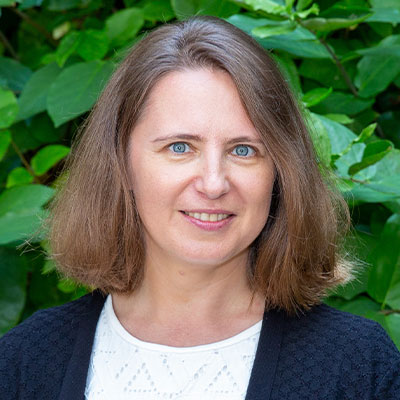

In [61]:
from IPython.display import Image, display

def show_picture(name):
    idx = faculty[faculty['name'].str.lower().str.contains(name.lower())].index[0]
    display(Image(divs[idx].find('img')['src'], width=200, height=200))
    
show_picture('marina')

<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a class="alert-link" href="http://q.dsc80.com">q.dsc80.com)</h3>

Consider the following HTML document, which represents a webpage containing the top few songs with the most streams on Spotify today in Canada.

```html
<head>
    <title>3*Canada-2022-06-04</title>
</head>
<body>
    <h1>Spotify Top 3 - Canada</h1>
    <table>
        <tr class='heading'>
            <th>Rank</th>
            <th>Artist(s)</th> 
            <th>Song</th>
        </tr>
        <tr class=1>
            <td>1</td>
            <td>Harry Styles</td> 
            <td>As It Was</td>
        </tr>
        <tr class=2>
            <td>2</td>
            <td>Jack Harlow</td> 
            <td>First Class</td>
        </tr>
        <tr class=3>
            <td>3</td>
            <td>Kendrick Lamar</td> 
            <td>N95</td>
        </tr>
    </table>
</body>
```

</div>

**Part 4**: Complete the implementation of the function `top_nth`, which takes in a positive integer `n` and returns the name of the n-th ranked song in the HTML document. For instance, `top_nth(2)` should evaluate to `"First Class"` (`n=1` corresponds to the top song).

Note: Your implementation should work in the case that the page contains more than 3 songs.

```py
def top_nth(n):
    return soup.find("tr", attrs=__(a)__).find_all("td")__(b)__
```

### Web data in practice

[The spread of true and false news online](https://www.science.org/doi/full/10.1126/science.aap9559) by Vosoughi et al. compared how true and false news spreads via Twitter:

> There is worldwide concern over false news and the possibility that it can influence political, economic, and social well-being. To understand how false news spreads, Vosoughi et al. used a data set of rumor cascades on Twitter from 2006 to 2017. About 126,000 rumors were spread by ∼3 million people. False news reached more people than the truth; the top 1% of false news cascades diffused to between 1000 and 100,000 people, whereas the truth rarely diffused to more than 1000 people. Falsehood also diffused faster than the truth. The degree of novelty and the emotional reactions of recipients may be responsible for the differences observed.

To conduct this study, the authors used the Twitter API for accessing tweets and web-scraped fact-checking websites to verify whether news was false or not.

## Summary, next time

- Beautiful Soup is an HTML parser that allows us to (somewhat) easily extract information from HTML documents.
    - `soup.find` and `soup.find_all` are the functions you will use most often.
- When writing scraping code:
    - Use "inspect element" to identify the names of tags and attributes that are relevant to the information you want to extract.
    - Separate your logic for making requests and for parsing.

### Next time

Regular expressions!